In [52]:
import pandas as pd
import numpy as np
import ipywidgets as ipw
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

# HiPrBind Data Analysis

### The purpose of this notebook is to check traces (via graphs) and replicate data (via correlation)

### First import the necessary packages in order to complete analysis

In [3]:
img_path = open('AbSciImg.jfif', 'rb')
img = img_path.read()
ipw.Image(value=img, format='jfif', height='200px', width='200px')

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xfe\x00;CREATOR: gd-jpe…

In [4]:
STYLE = {"description_width": "initial"}

#### Copy the file path and paste after the 'r' written below after 'file_path = r'

In [5]:
file_path = r"L:\Molecular Sciences\Small Scale Runs\SSF00626 DSS Spaniel_discrete chaperone set\Assays\HiPrBind\Processed\SSF00626_output.xlsx"

#### This next step is important for taking the data from the output file and putting it into a workable table in this notebook
##### ***It is important to note that the sheet_name must be indicated ***

In [6]:
full_calcs_df = pd.DataFrame()
full_display_df = pd.DataFrame()
full_calcs_rep_df = pd.DataFrame()
full_display_rep_df = pd.DataFrame()

calcs_df = pd.read_excel(file_path, index_col=0, sheet_name="Calculations")
display_df = pd.read_excel(file_path, index_col=0, sheet_name="Display_Ready")
calcs_reps_df = pd.read_excel(file_path, index_col=0, sheet_name="Rep_Calculations")
display_reps_df = pd.read_excel(file_path, index_col=0, sheet_name="Rep_Display_Ready")


full_calcs_df = pd.concat([full_calcs_df, calcs_df])
full_display_df = pd.concat([full_display_df, display_df])

full_calcs_rep_df = pd.concat([full_calcs_rep_df, calcs_reps_df])
full_display_rep_df = pd.concat([full_display_rep_df, display_reps_df])

stacked_calcs_df = pd.concat([full_calcs_df, full_calcs_rep_df])
stacked_display_df = pd.concat([full_display_df, full_display_rep_df])


#### If you want to check graphs by sample type ('Sample_type'), this step is necessary to remove any row that has a blank value in this column.

In [7]:
stacked_display_df.dropna(subset=["Sample_type"], how='any', inplace=True)

In [8]:
try:
    proj_name = stacked_display_df['SSF_exp'].unique()[0]
    print(proj_name)
except KeyError:
    print("No ID")

SSF00626


#### Now you can make the line graphs here. The traces of the  chart should like a 96-well source plate. 
#####        'facet_co= ' and 'facet_row= ' are determined by the 'Col' and 'Row' column from the file. These columns must exist! 
#####        'color= ' designate by color by a column, e.g. if you wanted to view the line color by sample type, type the column name for sample type e.g. 'Sample_type'
#####        'line_group= ' choose the column name that represent the line traces, e.g. if you want lines by specific plates, type the "Plate" column name. 
##### Charts may look odd if the wrong columns are picked for 'color= ' or 'line_group= ', so you may need to change the column name until it looks appropriate

#### Example Chart
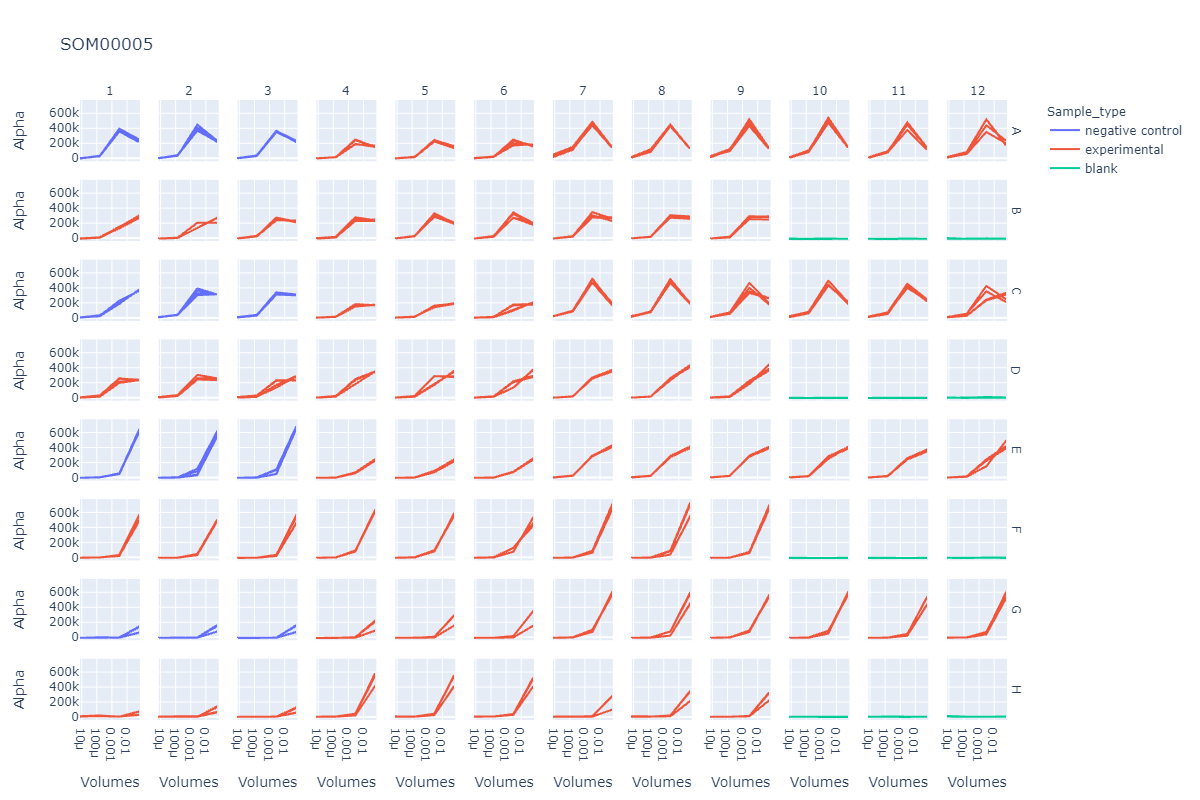

##### It's also important to note that these charts are interactive. In the legend, you can click on labels that you want to hide or reintroduce. E.g. If you want to see the charts without 'Standard' included, simply click on the 'Standard' label to hide it. 
##### *** If you want to color lines by "Strain_id" you will need to copy paste the "stacked_wo_std_display" and paste over "stacked_display_df" inside of px.line()

In [25]:
column_name = ipw.Dropdown(
    options=list(stacked_display_df.columns),
    description="Choose column to indicate color",
    style=STYLE,
    value='Sample_type'
)
plot_out = ipw.Output()
@plot_out.capture()
def create_traces(column_name):
    plot_out.clear_output()
    try:
        rep_lines = px.line(stacked_display_df, x="Volumes", y="Alpha", facet_col="Col", facet_row="Row", color=column_name, line_group="Plate", log_x=True,
                           height=800, width=1000, title=proj_name)
        rep_lines.update_xaxes(tickangle=45, tickfont=dict(size=8), title_font=dict(size=10))
        rep_lines.update_yaxes(tickangle=45, tickfont=dict(size=8), title_font=dict(size=10))
        rep_lines.update_traces(line=dict(width=0.8))

        rep_lines.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
        rep_lines.show()
    except KeyError:
        print("\nChoose a different column! This one doesn't work.")
    except ValueError:
        print("\nChoose a different columns! These values don't look right.")
trace_plot = ipw.interactive(create_traces, column_name=column_name)

display(plot_out, trace_plot);

Output()

interactive(children=(Dropdown(description='Choose column to indicate color', index=1, options=('SSF_exp', 'Sa…

In [10]:
stacked_wo_std_display = stacked_display_df[stacked_display_df["Sample_type"] != "Standard"]

In [26]:
strain_lines = px.line(stacked_wo_std_display, x="Volumes", y="Alpha", facet_col="Strain_id", color="Plate", line_group="Well_Id", log_x=True,
                   height=300, width=1000, title=proj_name)
strain_lines.update_xaxes(tickangle=45, tickfont=dict(size=8), title_font=dict(size=10))
strain_lines.update_yaxes(tickangle=45, tickfont=dict(size=8), title_font=dict(size=10))
strain_lines.update_traces(line=dict(width=0.8))
strain_lines.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

## Spearman correlation:  To analyze the replicate data, spearman correlation will be used here.

#### First, the columns with alpha signals for main and replicate data will be separated into separate columns

In [12]:
# plates_w_replicates = stacked_display_df[stacked_display_df["Plate"]]

In [13]:
sample_type = stacked_display_df[stacked_display_df["Plate"].str.contains("-1", case=False)]["Sample_type"].values
well_id = stacked_display_df[stacked_display_df["Plate"].str.contains("-1", case=False)]["Well_Id"].values
main_alpha = stacked_display_df[stacked_display_df["Plate"].str.contains("-1", case=False)]["Alpha"].values
rep_alpha = stacked_display_df[stacked_display_df["Plate"].str.contains("-2", case=False)]["Alpha"].values
strain = stacked_wo_std_display[stacked_wo_std_display["Plate"].str.contains("-1", case=False)]["Strain_id"].values
strain_main_alpha = stacked_wo_std_display[stacked_wo_std_display["Plate"].str.contains("-1", case=False)]["Alpha"].values
strain_rep_alpha = stacked_wo_std_display[stacked_wo_std_display["Plate"].str.contains("-1", case=False)]["Alpha"].values
strain_well_id = stacked_wo_std_display[stacked_wo_std_display["Plate"].str.contains("-1", case=False)]["Well_Id"].values

In [14]:
stats.spearmanr(main_alpha, rep_alpha)

SpearmanrResult(correlation=0.9915688465732392, pvalue=1.4532884117339645e-202)

#### For a visual representation, a Joint Plot will be created. The bars above, and to the side of the chart represent the density of scatter plots. 

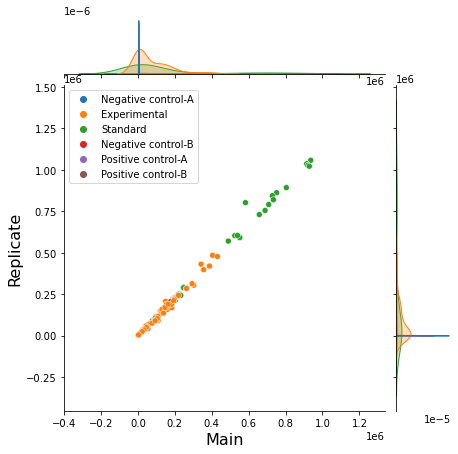

In [72]:
corr_plot = sns.jointplot(ax=axes[0], x=main_alpha, y=rep_alpha, 
                         hue=sample_type,
#                          palette={"No Wash":"blue", "PBS Wash":"red", "PBS+EDTA Wash": "green", "Blank":"purple", "Standard":"orange"}
                        )
corr_plot.set_axis_labels("Main", "Replicate", fontsize=16);

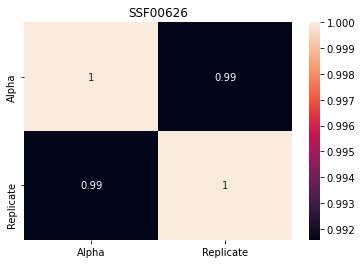

In [73]:
df = pd.DataFrame({"Alpha":main_alpha, "Replicate":rep_alpha})
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.title(proj_name);

In [22]:
line = px.scatter(x=main_alpha, y=rep_alpha, facet_col=sample_type, opacity=0.7, color=well_id, title=proj_name
# line.update_traces(mode="lines+markers")
line.update_layout(xaxis_title="Main")
# line.add_shape(type='line',
#                 x0=0,
#                 y0=200000,
#                 x1=1000000,
#                 y1=200000,
#                 line=dict(color='Red',),
# )
line.update_xaxes(title="Replicate", tickangle=45, tickfont=dict(size=8), title_font=dict(size=10))
line.update_yaxes(tickangle=45, tickfont=dict(size=8), title_font=dict(size=10))
# line.update_traces(line=dict(width=0.8))
line.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

In [74]:
strain_ids = stacked_wo_std_display["Strain_id"].unique()
strain_ids


array(['ABS08019', 'ABS24875', 'ABS24883', 'ABS24891', 'ABS24899',
       'ABS24876', 'ABS24884', 'ABS24892', 'ABS24584', 'ABS24877',
       'ABS24885', 'ABS24893', 'ABS24878', 'ABS24886', 'ABS24894',
       'ABS24871', 'ABS24879', 'ABS24887', 'ABS24895', 'ABS24872',
       'ABS24880', 'ABS24888', 'ABS24896', 'ABS24873', 'ABS24881',
       'ABS24889', 'ABS24897', 'ABS24874', 'ABS24882', 'ABS24890',
       'ABS24898'], dtype=object)

In [75]:
strain_data = {}
for id in strain_ids:
    strain_data[id] = pd.Series(stacked_wo_std_display[(stacked_wo_std_display["Strain_id"] == id) & (stacked_wo_std_display["Plate"].apply(lambda x: int(x.split('-')[1]) == 1))]["Alpha"].values)

main_strain_df = pd.concat(strain_data, axis=1)

for id in strain_ids:
    strain_data[id] = pd.Series(stacked_wo_std_display[(stacked_wo_std_display["Strain_id"] == id) & (stacked_wo_std_display["Plate"].apply(lambda x: int(x.split('-')[1]) == 2))]["Alpha"].values)

rep_strain_df = pd.concat(strain_data, axis=1)
#     main_strain_df = pd.concat([main_strain_df, strain_df], axis=1)
# print(main_strain_df.head(2))


    
    

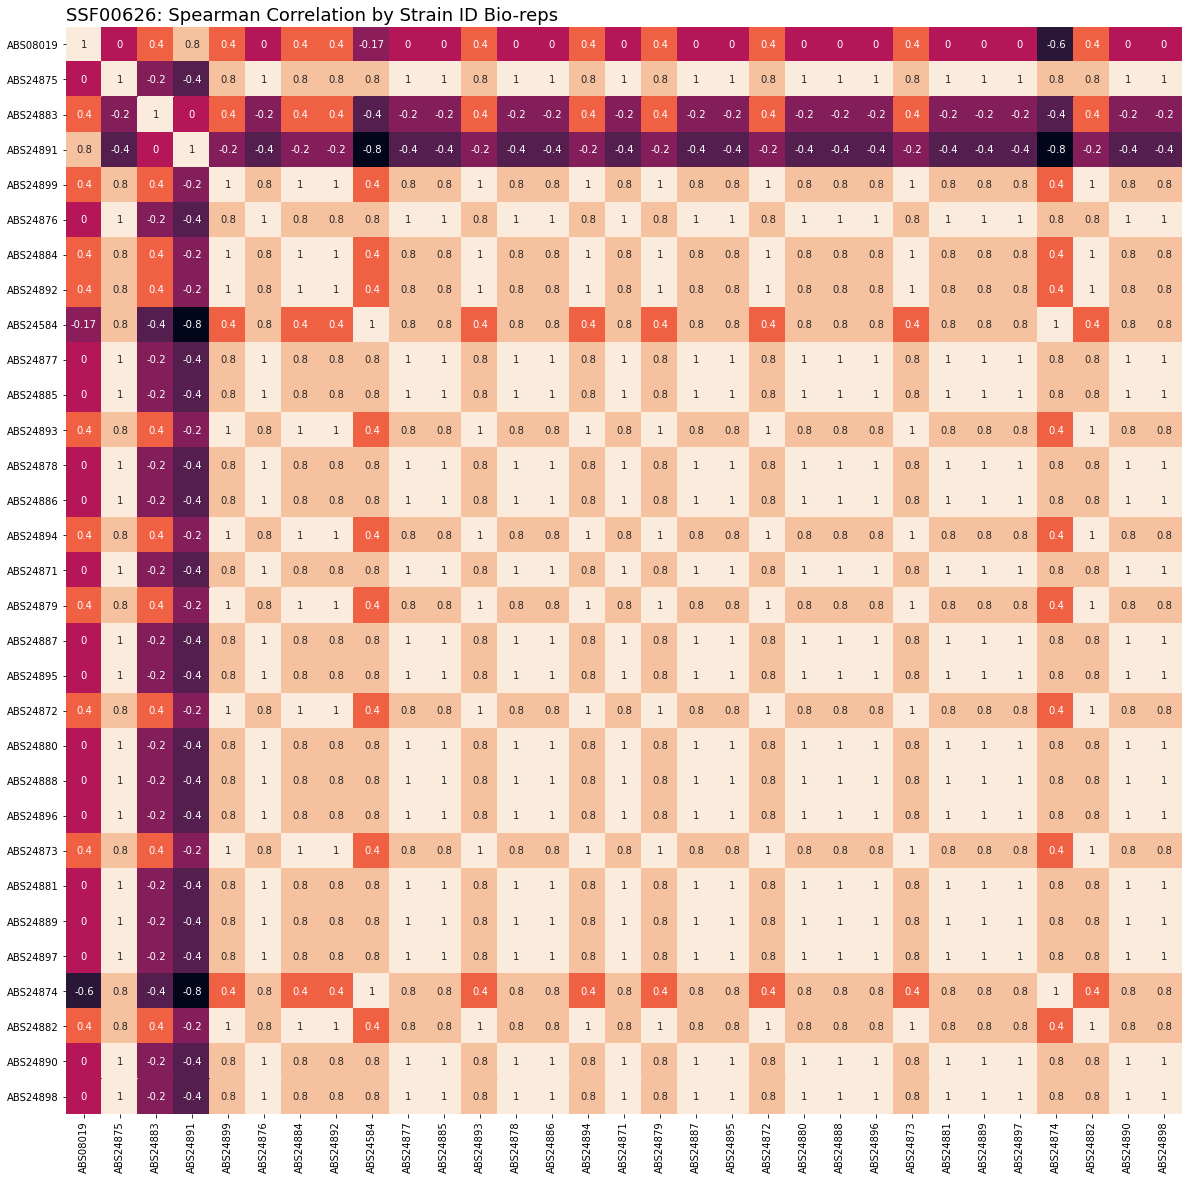

In [90]:
plt.figure(figsize=(20, 20))
main_corr = main_strain_df.corr(method='spearman')
sns.heatmap(main_corr, annot=True, cbar=False)
plt.title(f'{proj_name}: Spearman Correlation by Strain ID Bio-reps', fontsize=18, loc='left');

In [ ]:
for id in strain_ids:
    print(f"{id}\n{stats.spearmanr(main_strain_df[id].values, rep_strain_df[id].values)}")
    

In [ ]:
strain_line = px.scatter(
    x=strain_main_alpha, 
    y=strain_rep_alpha, 
    facet_col=strain, 
    opacity=0.7, 
    width=1000, 
    height=300,
    color=strain_well_id)
# line.update_traces(mode="lines+markers")
strain_line.update_xaxes(title_text="Main")
strain_line.update_layout(yaxis_title="Replicate")
strain_line.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

In [91]:
stacked_wo_std_display.insert(1, "Name_Well", stacked_wo_std_display["SSF_exp"] + "-" + stacked_wo_std_display["Well_Id"] + "-" + stacked_wo_std_display["Volumes"].apply(lambda x: str(x)))

In [92]:
stacked_wo_std_display["Name_Well"].shape

(264,)

In [93]:
mean_stacked_wo_std_display = stacked_wo_std_display.groupby(["Name_Well", "Well_Id", "Strain_id"], as_index=False).agg({"Alpha": "mean"})
mean_stacked_wo_std_display.shape

(132, 4)

In [95]:
main_strain_df = []
for id in strain_ids:
    strain_data = mean_stacked_wo_std_display[mean_stacked_wo_std_display["Strain_id"] == id][["Alpha", "Well_Id", "Strain_id"]]

    strain_data.set_index([pd.Index([x for x in range(0, strain_data.shape[0])])], inplace=True)
    main_strain_df.append(strain_data)
print(main_strain_df[0])

    Alpha Well_Id Strain_id
0  2311.0     A01  ABS08019
1  1986.0     A01  ABS08019
2  1906.0     A01  ABS08019
3  3545.0     A01  ABS08019
4  2136.5     B01  ABS08019
5  1904.5     B01  ABS08019
6  1867.5     B01  ABS08019
7  3931.0     B01  ABS08019


In [102]:
corr_df_list = []
for df in main_strain_df:
    well_ids = df["Well_Id"].unique()
    strain_id = df["Strain_id"].unique()
    print(well_ids)
    print(strain_id)
    well_data = {}
    
    if len(well_ids) > 1:
        for id in well_ids:
            well_data[id] = pd.Series(df[df["Well_Id"] == id]["Alpha"].values)
        well_df = pd.concat(well_data, axis=1)
        print(well_df)
        corr = well_df.corr(method='spearman')
        corr_df_list.append(corr)
print(corr_df_list)
#         sns.heatmap(corr, annot=True, cbar=False)
#     print(well_ids[1])
#     rho, p = stats.spearmanr(well_df)
#     print(rho)
#     strain_data[id] = pd.Series(stacked_wo_std_display[(stacked_wo_std_display["Strain_id"] == id) & (stacked_wo_std_display["Plate"].apply(lambda x: int(x.split('-')[1]) == 1))]["Alpha"].values)

# main_strain_df = pd.concat(strain_data, axis=1)

['A01' 'B01']
['ABS08019']
      A01     B01
0  2311.0  2136.5
1  1986.0  1904.5
2  1906.0  1867.5
3  3545.0  3931.0
['A02']
['ABS24875']
['A03']
['ABS24883']
['A04']
['ABS24891']
['A05']
['ABS24899']
['B02']
['ABS24876']
['B03']
['ABS24884']
['B04']
['ABS24892']
['C01' 'D01']
['ABS24584']
        C01       D01
0    4187.5    5455.5
1   38370.5   46697.0
2  204680.5  191571.0
3   38276.0   32652.5
['C02']
['ABS24877']
['C03']
['ABS24885']
['C04']
['ABS24893']
['D02']
['ABS24878']
['D03']
['ABS24886']
['D04']
['ABS24894']
['E01']
['ABS24871']
['E02']
['ABS24879']
['E03']
['ABS24887']
['E04']
['ABS24895']
['F01']
['ABS24872']
['F02']
['ABS24880']
['F03']
['ABS24888']
['F04']
['ABS24896']
['G01']
['ABS24873']
['G02']
['ABS24881']
['G03']
['ABS24889']
['G04']
['ABS24897']
['H01']
['ABS24874']
['H02']
['ABS24882']
['H03']
['ABS24890']
['H04']
['ABS24898']
[     A01  B01
A01  1.0  1.0
B01  1.0  1.0,      C01  D01
C01  1.0  1.0
D01  1.0  1.0]


     A01  B01
A01  1.0  1.0
B01  1.0  1.0
     C01  D01
C01  1.0  1.0
D01  1.0  1.0


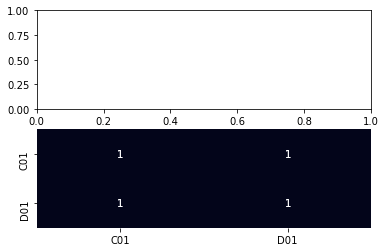

In [106]:
fig, axes = plt.subplots(len(corr_df_list))
for corr in range(0, len(corr_df_list)):
    print(corr_df_list[corr])
    axes[corr] = sns.heatmap(corr_df_list[corr], annot=True, cbar=False)

In [ ]:
# rho, pval = stats.spearmanr(x2n)

In [ ]:
# rho